# HW3 due 5p Fri Oct 30 2020

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your submission (e.g. the .ipynb file).

You are welcome to consult websites, textbooks, and other materials; if you do, include a full citation in your writeup (e.g. the .ipynb file).

**Important:** before you do any work in the Colaboratory notebook, click "File -> Save a copy in Drive ..." and rename the file to something memorable.


# 0. [preferred name]; [preferred pronouns]

a. Approximately how many hours did you spend on this assignment?

b. Were there specific problems that took much longer than others?

c. What class meeting(s) did you participate in this week?

d. What timezone(s) were you working in this week?

# 1. proportional-integral control

This problem considers the following standard negative feedback block diagram.

![negative feedback block diagram](http://faculty.washington.edu/sburden/447/447-hw1-feedback.png)

***Purpose:*** you will analyze and synthesize a ***proportional-integral*** controller
$$ C(s) = k_P + k_I/s \iff u(t) = k_P e(t) + k_I \int_0^t e(\tau) d\tau $$ 
for the purpose of ***reference tracking***.  Specifically, you'll apply this controller to a first-order process model $P(s) = b / (s + a)$ to obtain the closed-loop transfer function $G_{yr}$.

**We seek to tune the controller parameters $k_P, k_I$ to obtain complex-conjugate roots $-\sigma_d \pm j \omega_d$ for the closed-loop system, i.e. we want the characteristic polynomial of $G_{yr}$ to be
$$(s + \sigma_d + j \omega_d) (s + \sigma_d - j \omega_d) = s^2 + 2\sigma_d s + \sigma_d^2 + \omega_d^2.$$**

a. By matching coefficients that multiply the same power of the variable $s$ in the actual and desired characteristic polynomials, express $k_P$ and $k_I$ in terms of $\sigma_d,\omega_d,a,b$.

**Solution:**\
First, find the transfer function $G_{yr}(s)$. According to the block diagram:\
$(C(s)(r-y)+v)P(s)=y$\
$\iff (PC+1)y=PCr+Pv$ (omitting (s))\
$\Rightarrow y= \frac{PC}{1+PC}r$\
$\Rightarrow G_{yr}(s) = \frac{P(s)C(s)}{1+P(s)C(s)}$\
Plug in $P = \frac{b}{s+a}, C = \frac{k_Ps+k_I}{s}$\
$\Rightarrow G_{yr}(s) = \frac{k_Pbs+k_Ib}{s^2+(a+k_Pb)s+k_Ib}$

From the transfer function, we know the characteristic polynomial:
$a(s)=s^2+(a+bk_P)s+bk_I$.\
On matching coefficients with the desired polynomial, we have $\fbox{$k_I= \frac{\sigma_d^2 +\omega_d^2}{b}$}$.\
Similarly, $2\sigma_d=(a+bk_P) \Rightarrow \fbox{$k_P=(2\sigma_d-a)/b$}$ as the desired parameters.

--------------------------------

b. Validate your result from (a) using a numerical simulation of the closed-loop system with parameters $a = 1$, $b = 1$:  choose $\sigma_d$, $\omega_d$, determine the corresponding $k_P$, $k_I$, and plot the system's ***step response***, that is, the output corresponding to a reference $r(t)$ that is equal to zero for $t < 0$ and equal to $1$ for $t \geq 0$.

**Solution:**\
According to the transfer function 
$G_{yr}(s) = \frac{k_Pbs+k_Ib}{s^2+(a+k_Pb)s+k_Ib}$\
Write it into DE format:
$\frac{d}{dt}\left[\begin{matrix} y \\ \dot{y} \end{matrix}\right] = \left[\begin{matrix} 0 & 1 \\ -k_Ib & -a-k_Pb \end{matrix}\right]\left[\begin{matrix} y \\ \dot{y} \end{matrix}\right] - \left[\begin{matrix} 0 \\ k_Ib \end{matrix}\right]r$\
Then, numerically simulate the system


In [33]:
# import modules first
import numpy as np
import pylab as plt
from scipy.integrate import solve_ivp

# build ODE solver
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

[-0.68337521 -7.31662479]


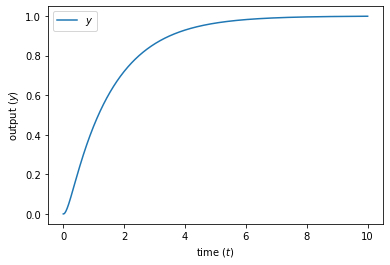

In [34]:
# code for b. goes here
a = 1
b = 1

sig = 4
omg = 1

k_i = (sig^2 + omg^2)/b
k_p = (2*sig - a)/b

A = np.array([[0, 1],
              [-k_i*b, -a-k_p*b]])

eigenvalue, _ = np.linalg.eig(A)
print(eigenvalue)

B = np.array([[0],
              [k_i*b]])

def f(t,x,u):
  #x1,x2 = x
  y = np.squeeze(np.dot(x, A.T) + u * B.T)
  return y

dt = 1e-2
# initial condition
y0 = np.array([0, 0])

# simulation time−−
t = 10


time_, y_ = numerical_simulation(f,t,y0,dt=dt,ut=lambda t : 1)

y, dy = y_[:,0], y_[:,1]

plt.figure()
plt.plot(time_, y,label=r'$y$') # label this line for inclusion in a legend
plt.xlabel(r'time ($t$)')
plt.ylabel(r'output ($y$)')
plt.legend() # adds legend using label's specified in plot(...) commands







**According to the preceding analyses, the convergence rate can be made arbitrarily fast (i.e. $\sigma_d$ can be made arbitrarily large) by making the controller parameters $k_P,k_I$ large. In practice, such *high-gain feedback* can excite *unmodeled dynamics* and lead to instability.**

**To see how this can happen, suppose unmodeled dynamics in $P(s)$ (e.g. dynamics of sensors, actuators, vibratory modes, electromagnetic coupling, etc.) have time constant $T > 0$ (assume $-1/T \ll -a$, so we were initially justified in neglecting these dynamics in our model because they are stable and converge much faster than the original modeled dynamics).  Including these dynamics yields the process model**

$$ P(s) = \frac{b}{(s + a)(1 + sT)}. $$

c. Determine the characteristic polynomial of the closed-loop transfer function $G_{yr}$.

**Solution:**

By substituting the value of C(s) from 1a. and P(s) provided above, we can obtain the transfer function G_{yr}(s). For the closed-loop characteristic polynomial, we look at the denominator of G_{yr}(s), which is:   

$a(s) = s(s + a)(1+sT)+bk_Ps+bk_I$  
$ \Leftrightarrow a(s) = s^3T + (1 + aT)s^2 + (a+bk_P)s + bk_I$   


 -----------------------

d. Apply the *Routh-Hurwitz stability criterion* to determine algebraic conditions that must be satisfied by $a,b,k_P,k_I,T$ for the closed-loop system to be stable.

**Solution:**

$a(s)=s^3+(\frac{1}{T}+a)s^2+\frac{(a+bk_P)}{T}s + \frac{bk_I}{T}$

Using the Routh-Hurwitz criterion, $a_1,a_2,a_3 > 0$ and $a_1a_2 > a_3$

(1)$$\frac{1}{T}+a > 0$$  
(2)$$\frac{(a+bk_P)}{T} > 0$$  
(3)$$\frac{bk_I}{T} > 0$$  

and

(4)$$(\frac{1}{T}+a) \frac{(a+bk_P)}{T} > \frac{bk_I}{T}$$ $$ \Leftrightarrow \frac{(1+aT)(a+bk_P)}{bk_I} > T$$
 

-----------------------------

e. Validate your result from (d) using a numerical simulation of the closed-loop system with $a = 1$, $b = 1$, $T = 0.1$:  choose $k_P$, $k_I$ such that the Routh-Hurwitz criteria are (i) satisfied (so the closed-loop system is stable) and (ii) violated (so the closed-loop system is unstable), and provide plots showing the step response in these two cases.

**Solution:**\
According to the transfer function 
$G_{yr}(s) = \frac{\frac{k_Pb}{T}s+\frac{k_Ib}{T}}{s^3+\frac{aT+1}{T}s^2+\frac{a+k_Pb}{T}s+\frac{k_Ib}{T}}$\
Write it into DE format:
$\frac{d}{dt}\left[\begin{matrix} y \\ \dot{y} \\ \ddot{y} \end{matrix}\right] = \left[\begin{matrix} 0 & 1 & 0 \\ 0 & 0 & 1 \\ -\frac{k_Ib}{T} & -\frac{a+k_Pb}{T} & -\frac{aT+1}{T} \end{matrix}\right]\left[\begin{matrix} y \\ \dot{y} \\ \ddot{y} \end{matrix}\right] - \left[\begin{matrix} 0 \\ 0 \\ \frac{k_Ib}{T} \end{matrix}\right]r$\
Then, numerically simulate the system

condition (4) violated


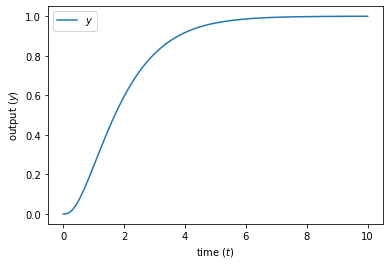

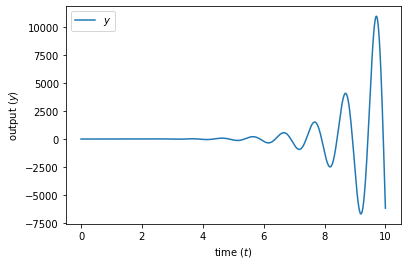

In [35]:
# code of e goes here

# first, use k_i and k_p that satisfy Routh-Hurwitz criterion -------------------
a = 1
b = 1

k_i = 1
k_p = 1

T = 0.1

# check Routh-Hurwitz criterion
if (1/T + a) <= 0:
  print('condition (1) violated')
if (a+k_p*b)/T <= 0:
  print('condition (2) violated')
if k_i*b/T <= 0:
  print('condition (3) violated')
if (1/T + a)*(a+k_p*b) <= b* k_i :
  print('condition (4) violated')


A = np.array([[0, 1, 0],
              [0, 0, 1],
              [-k_i*b/T, -(a+k_p*b)/T, -(a*T + 1)/T]])

B = np.array([[0],
              [0],
              [k_i*b/T]])

def f(t,x,u):
  #x1,x2 = x
  y = np.squeeze(np.dot(x, A.T) + u * B.T)
  return y

dt = 1e-2
# initial condition
y0 = np.array([0, 0, 0])

# simulation time−−
t = 10


time_, y_ = numerical_simulation(f,t,y0,dt=dt,ut=lambda t : 1)

y, dy, ddy = y_[:,0], y_[:,1], y_[:,2]

plt.figure()
plt.plot(time_, y,label=r'$y$') # label this line for inclusion in a legend
plt.xlabel(r'time ($t$)')
plt.ylabel(r'output ($y$)')
plt.legend() # adds legend using label's specified in plot(...) commands


# next, use k_i and k_p that violate Routh-Hurwitz criterion -------------------
a = 1
b = 1

k_i = 50
k_p = 1

T = 0.1

# check Routh-Hurwitz criterion
if (1/T + a) <= 0:
  print('condition (1) violated')
if (a+k_p*b)/T <= 0:
  print('condition (2) violated')
if k_i*b/T <= 0:
  print('condition (3) violated')
if (1/T + a)*(a+k_p*b) <= b* k_i :
  print('condition (4) violated')


A = np.array([[0, 1, 0],
              [0, 0, 1],
              [-k_i*b/T, -(a+k_p*b)/T, -(a*T + 1)/T]])

B = np.array([[0],
              [0],
              [k_i*b/T]])

def f(t,x,u):
  #x1,x2 = x
  y = np.squeeze(np.dot(x, A.T) + u * B.T)
  return y

dt = 1e-2
# initial condition
y0 = np.array([0, 0, 0])

# simulation time−−
t = 10


time_, y_ = numerical_simulation(f,t,y0,dt=dt,ut=lambda t : 1)

y, dy, ddy = y_[:,0], y_[:,1], y_[:,2]

plt.figure()
plt.plot(time_, y,label=r'$y$') # label this line for inclusion in a legend
plt.xlabel(r'time ($t$)')
plt.ylabel(r'output ($y$)')
plt.legend() # adds legend using label's specified in plot(...) commands


# 2. spring-mass-damper a deux
Consider the following spring-mass-damper system:
![spring-mass](http://faculty.washington.edu/sburden/447/447-hw1-spring-mass.png)
The input to this system is the sinusoidal motion of the end of the rightmost spring. 
Applying Newton's laws to determine the forces acting on both masses, we find two coupled second-order DE that model the system's dynamics:

$$ m\ddot{q}_1 = - c \dot{q}_1 - k q_1 + k (q_2 - q_1), $$

$$ m\ddot{q}_2 = - c \dot{q}_2 + k (u - q_2) - k (q_2 - q_1). $$

## change-of-coordinates

***Purpose:*** observe how a clever change-of-coordinates can simplify analysis of a complex system's dynamics.  ***Note:*** you ***do not*** need to solve the DEs in (a.--d.).

a. Combine the two second-order DE above to obtain one fourth-order DE with $u$ as the input and $q_1$ as the output.  (***Note:*** this DE is hard to solve -- since the characteristic polynomial is fourth-order, you can't easily solve for the roots needed to obtain the ***homogeneous solution***.)

**Solution:**

From the first equation, we get:

$q_2 = \frac{m}{k}\ddot{q_1} + \frac{c}{k}\dot{q_1} + 2q_1$

Now, substituting this in the second equation, we get: 

$$ m\ddot{q}_2 = - c \dot{q}_2 + k (u - q_2) - k (q_2 - q_1). $$

$$\Leftrightarrow m(\frac{m}{k}\ddddot{q_1} + \frac{c}{k}\dddot{q_1} + 2\ddot{q_1}) = - c (\frac{m}{k}\dddot{q_1} + \frac{c}{k}\ddot{q_1} + 2\dot{q_1}) + k (u - (\frac{m}{k}\ddot{q_1} + \frac{c}{k}\dot{q_1} + 2q_1)) - k ((\frac{m}{k}\ddot{q_1} + \frac{c}{k}\dot{q_1} + 2q_1) - q_1). $$

$$\Leftrightarrow \frac{m^2}{k}\ddddot{q_1} + \frac{2mc}{k}\dddot{q_1} + (4m + \frac{c^2}{k})\ddot{q_1} + 4c\dot{q_1} + 3kq_1= ku$$

----------------------------------------------------------

b. Rewrite the original two second-order DE in terms of 
$p_1 = \frac{1}{2}(q_1 + q_2)$ 
and 
$p_2 = \frac{1}{2} (q_1 - q_2)$.  (***Note:*** you should now have two second-order DE that are decoupled, that is, they can be solved independently; two second-order DE are ***much*** easier to solve than the one fourth-order DE you obtained in (a.).)

**Solution:**

The problem statement has been split into two parts above.  The first part is straightforward; the second part may be more or less laborious, depending on the approach adopted.

### first part
To obtain theorder DE in terms of the new variables 
$p_1 = \frac{1}{2}(q_1 + q_2)$ 
and 
$p_2 = \frac{1}{2} (q_1 - q_2)$,
we differentiate and substitute
$q_1 = p_1 + p_2$,
$q_2 = p_1 - p_2$:

$$ \ddot{p}_1 = \frac{1}{2}(\ddot{q}_1 + \ddot{q}_2) = \frac{1}{m}( -c \dot{p}_1 - k p_1 + \frac{k}{2} u ), $$

$$ \ddot{p}_2 = \frac{1}{2}(\ddot{q}_1 - \ddot{q}_2) = \frac{1}{m}( -c \dot{p}_2 -3 k p_2 - \frac{k}{2} u ).$$




### second part

The crucial observation is that whereas the DE in the $q$ coordinates are coupled, the DE in the $p$ coordinates are *decoupled* (i.e. $\ddot{z}_1$ does not depend on $p_2,\dot{p}_2$ and vice-versa) -- this has several important implications / interpretations.

First, both DE follow the same general form of a linear time-invariant DE (LTI-DE)

$$ \ddot{p} + a_1 \dot{p}_1 + a_2 p = b u, $$

where the coefficients $a_1,a_2,b$ can be determined by matching terms with the same order of derivative:
- substituting $a_1 = c/m$, $a_2 = k/m$, $b = k/2m$ yields the equation for $\ddot{p}_1$;
- substituting $a_1 = c/m$, $a_2 = 3k/m$, $b = k/2m$ yields the equation for $\ddot{p}_2$.

If we derive an expression for the solution of a general second-order DE (i.e. solve for $p(t)$), then this expression can be specialized to the particular second-order DE by substitution.  We know from lecture that the solution of a second-order LTI-DE has the general form

$$ p(t) = c_1 e^{s_1 t} + c_2 e^{s_2 t} + G(s) e^{s t} $$

where
$s_1,s_2$ are the roots of the *characteristic polynomial* $a(s) = s^2 + a_1 s + a_2$ and $G(s) = \frac{b}{a(s)}$ is the *transfer function*, both of which can be obtained directly by inspecting the DE.  The constants $c_1$, $c_2$ are determined from the *initial condition* $(p(0),\dot{p}(0))$, and we have assumed for simplicity that the input is a single (complex) exponential $u(t) = e^{s t}$.

Actually, to conclude that the solution has the particular form above, we would need to know that the characteristic polynomial does not have repeated roots, because if it's the case that $s_1$ is the only complex number for which $a(s_1) = 0$ then the solution has the general form

$$ p(t) = c_1 e^{s_1 t} + c_2 t e^{s_1 t} + G(s) e^{s t}, $$

as we saw on the previous homework.

**Takeaway:** by changing coordinates (from the $q$'s to the $p$'s), we only needed to solve 2 decoupled second-order DE, rather than 1 coupled fourth-order DE.

--------------------------------------------------

c. Translate the original two DE to matrix/vector form using state vector $x = (q_1,\dot{q_1},q_2,\dot{q_2})$ (i.e. determine matrices $A$, $B$ such that $\dot{x} = A x + B u$).

**Solution:**\
Defining $x = (q_1, \dot{q}_1, q_2, \dot{q}_2)$, we can transcribe the two coupled second-order DE obtained above into one first-order DE in matrix/vector form:

$$ \dot{x} = \left[ \begin{matrix} \dot{q}_1 \\ \ddot{q}_1 \\ \dot{q_2} \\ \ddot{q_2} \end{matrix} \right] = \left[ \begin{matrix} 0 & 1 & 0 & 0 \\ -\frac{2k}{m} & -\frac{c}{m}& +\frac{k}{m}  & 0 \\ 0 & 0 & 0 & 1 \\ +\frac{k}{m} & 0 & - \frac{2k}{m} & -\frac{c}{m} \end{matrix} \right] \left[ \begin{matrix} {q}_1 \\ \dot{q}_1 \\ {q_2} \\ \dot{q_2} \end{matrix} \right] + \left[ \begin{matrix} 0 \\ 0 \\ 0 \\ \frac{k}{m} \end{matrix} \right] u = A x + b u. $$
--------------------------------------

d. Translate the two DE from (b.) to matrix/vector form using state vector $z = (p_1,\dot{p}_1,p_2,\dot{p}_2)$.  Noting that the system's $``A"$ matrix is block-diagonal, determine $A_1, A_2\in\mathbb{R}^{2\times 2}$ and $B_1, B_2\in\mathbb{R}^{2\times 1}$ such that
$$ \dot{z} = \left[ \begin{matrix} A_1 & 0 \\ 0 & A_2 \end{matrix} \right] z + \left[ \begin{matrix} B_1 \\ B_2 \end{matrix} \right] u.$$

**Solution:**\
Transcribing to matrix/vector form with $z = (p_1,\dot{p}_1,p_2,\dot{p}_2)$,

$$ \dot{z} = \left[ \begin{matrix} \dot{p}_1 \\ \ddot{p}_1 \\ \dot{p}_2 \\ \ddot{p}_2 \end{matrix} \right] = \left[ \begin{matrix} 0 & 1 & 0 & 0 \\ -\frac{k}{m} & -\frac{c}{m} & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -\frac{3k}{m} & -\frac{c}{m} \end{matrix} \right] \left[ \begin{matrix} z_1 \\ \dot{z}_1 \\ z_2 \\ \dot{z}_2 \end{matrix} \right] + \left[ \begin{matrix} 0 \\ +\frac{k}{2m} \\ 0 \\ -\frac{k}{2m} \end{matrix} \right]u $$

***Observe:***  in matrix/vector form, decoupling between subsystems manifests with block-diagonal structure in the $``A"$ matrix.


***Bonus (1 point for correctness):*** determine the matrix $T$ such that $z = T x$.

**Solution:**\
$$ z = \left[ \begin{matrix} {p}_1 \\ \dot{p}_1 \\ {p}_2 \\ \dot{p}_2 \end{matrix} \right] = \left[ \begin{matrix} 
1/2 & 0 & 1/2 & 0 \\ 
0 & 1/2 & 0 & 1/2 \\ 
1/2 & 0 & 1/2 & 0 \\ 
0 & 1/2 & 0 & 1/2 \\ 
\end{matrix} \right] \left[ \begin{matrix} q_1 \\ 
\dot{q}_1 \\ q_2 \\ \dot{q}_2 \end{matrix} \right] = Tx $$



## resonance

***Purpose:*** use computational tools to investigate a complex system's steady-state behavior in the time- and frequency- domain.

e. Setting $m = 250$, $k = 50$, $c = 10$, plot the motion of the first and second masses in response to an
input motion $u = a \sin(\omega t)$ with $\omega = 1$ rad/sec and $a = 1$ cm. 
How long does it take for the system to reach $2\%$ of its steady-state oscillation amplitude starting from the origin?


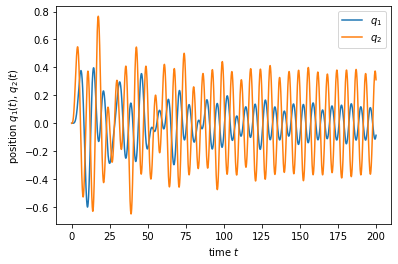

In [36]:
# we'll use the NumPy package for numerical / matrix computations
import numpy as np

# parameters
# the problem statement specifies m = 250, 
# but this has a very long settling time;
# for clarity in this solution, I chose a 
# smaller value for the mass
m = 250. 
c = 10.
k = 50.
A = 1.
omega = 1.

# vector field
def f(t,x,u):
  q1,q2,dq1,dq2 = x
  ddq1 = (-c*dq1 - k*q1 + k*(q2-q1)) / m
  ddq2 = (-c*dq2 + k*(u-q2) - k*(q2-q1)) / m
  return np.array([dq1,dq2,ddq1,ddq2])

# simulation duration, timestep
T = 200.
dt = 1e-2

# zero initial state
x0 = np.zeros(4)

# sinusoidal input
def u(t):
  ut = A*np.sin(omega*t)
  return ut

# this could equivalently be written in one line:
# u = lambda t : A*np.sin(omega*t)

# numerical simulation returns:
# t_ - size N array
# x_ - size N x 4 array (since the state is 4-dimensional)
t_,x_ = numerical_simulation(f,T,x0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
q1_,q2_ = x_[:,0],x_[:,1]

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt

# plot theta
plt.plot(t_,q1_,label=r'$q_1$')
plt.plot(t_,q2_,label=r'$q_2$')
plt.xlabel(r'time $t$')
plt.ylabel(r'position $q_1(t)$, $q_2(t)$')
plt.legend()

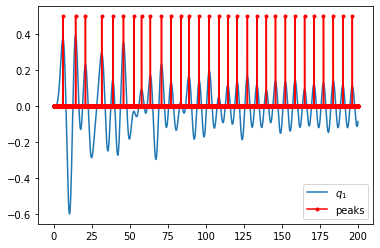

In [37]:
# Boolean array indicating times where signal is increasing
increasing = np.diff(q1_) > 0
# Boolean array indicating times where signal goes from increasing to decreasing
# (i.e. the peaks / local maxima in the signal)
peaks = np.diff(1*increasing) < 0
# each diff decreases length by 1, so let's append and prepend a False
peaks = np.hstack((False,peaks,False))

# let's confirm this computation correctly detects peaks
plt.plot(t_,q1_,label=r'$q_1$')
plt.plot(t_,0.5*peaks,'r.-',label='peaks')
plt.legend()

steady-state amplitude reached after 27 peaks (183.7 time units)


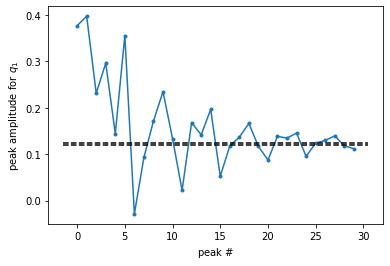

In [38]:
# the peaks calculation checks out -- now let's extract the peak values of q1
# and compute the steady-state amplitude by averaging the last 10 peaks
steady_state = q1_[peaks][-10:].mean()

# we can visualize the +/- 2% range specified in the problem statement
plt.plot(q1_[peaks],'.-')
xlim = plt.xlim()
plt.plot(xlim,1.02*steady_state*np.ones(2),'k--')
plt.plot(xlim,0.98*steady_state*np.ones(2),'k--')
plt.xlabel(r'peak $\#$')
plt.ylabel(r'peak amplitude for $q_1$')

# we can also compute how many peaks / how much time is required to reach +/- 2%
converged = np.abs((q1_[peaks] - steady_state)/steady_state > 0.02)
print('steady-state amplitude reached after %d peaks (%0.1f time units)'
      % (converged.nonzero()[0][-1],t_[peaks][converged][-1]))

f. Plot the steady-state amplitude of the motion of the first mass as a function of the frequency of the input, $\omega$.  (***Hint:***  you can either derive the transfer function from your answer to (a.) above, or you can run many (~100) simulations to create this plot; experiment with different ranges of $\omega$ until you find a range that demonstrates two resonant frequencies (sharp peaks) in the plot.  You may find it helpful to use the `numerical_simulation` function defined and applied in the [lecture examples notebook](https://colab.research.google.com/github/sburden/447/blob/master/447_lec_examples.ipynb).)

Text(0, 0.5, 'steady-state amplitude')

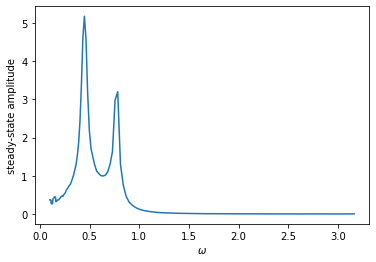

In [39]:
# here's where we specify the values of omega we will test
omegas = np.logspace(-1,.5,100)

# here's where we'll store the steady-state oscillation amplitude
steady_states = []

for omega in omegas:
  u = lambda t : A*np.sin(omega*t)
  t_,x_ = numerical_simulation(f,T,x0,ut=u,dt=dt)
  q1_,q2_ = x_[:,0],x_[:,1]
  increasing = np.diff(q1_) > 0
  peaks = np.diff(1*increasing) < 0
  peaks = np.hstack((False,peaks,False))
  steady_state = q1_[peaks][-10:].mean()
  steady_states.append(steady_state)

steady_states = np.asarray(steady_states)

plt.plot(omegas,steady_states)
plt.xlabel(r'$\omega$')
plt.ylabel(r'steady-state amplitude')

# 3. parametric stability

Consider the linear system

$$ \dot{x} = \left[\begin{matrix} 0 & 1 \\ 0 & -3 \end{matrix}\right]x + \left[\begin{matrix} -1 \\ 4 \end{matrix}\right] u. $$

## open-loop system

***Purpose:*** assess stability of an uncontrolled ("open-loop") system in state-space form using eigenvalues.

First, we'll consider the *open-loop* linear system's $``A"$ matrix,

$$ A = \left[\begin{matrix} 0 & 1 \\ 0 & -3 \end{matrix}\right]. $$

a. What are the eigenvalues of $A$?  How did you determine them?

**Solution:**

Eigenvalues are determined by the fomula $$\operatorname{det}(A-\lambda I) = 0$$

$\operatorname{det}\left(\left[\begin{matrix} 0 & 1 \\ 0 & -3 \end{matrix}\right] - \lambda\left[\begin{matrix} 1 & 0 \\ 0 & 1 \end{matrix}\right]\right) = 0$   

$\Leftrightarrow (-\lambda)(-3-\lambda) = 0$   
$\Leftrightarrow\lambda = 0, -3$

----------------------------------------------

b. Is this system stable (all eigenvalues have negative real part) or unstable (one or more eigenvalues has zero or positive real part)?

**Solution:**    
Since the real part of one eigenvalue is equal to 0, the system is unstable.

----------------------------------------------

## closed-loop system

***Purpose:*** assess stability of a controlled ("closed-loop") system in state-space form using eigenvalues as a function of a parameter.

Now we'll consider the effect of the output feedback $u = \left[\begin{matrix} -k & 0 \end{matrix}\right] x$, which results in the following ***closed-loop*** $``A"$ matrix for the linear system:

$$ A = \left[\begin{matrix} k & 1 \\ -4k & -3 \end{matrix}\right]. $$

c. What are the eigenvalues of $A$?  How did you determine them?

**Solution:**

Eigenvalues are determined by the fomula $$\operatorname{det}(A-\lambda I) = 0$$

$\operatorname{det}\left(\left[\begin{matrix} k & 1 \\ -4k & -3 \end{matrix}\right] - \lambda\left[\begin{matrix} 1 & 0 \\ 0 & 1 \end{matrix}\right]\right) = 0$     

$\Leftrightarrow \lambda^2 + (3-k)\lambda + k = 0$    
$\Leftrightarrow \lambda = \frac{-(3-k) \pm \sqrt{(3-k)^2 - 4k}}{2}$

-----------------------------------------------------------

d. Plot the eigenvalues of $A$ in the complex plane for $k\ge 0$; annotate the plot with several values of $k$.

***Takeaway:*** this kind of plot is termed a ***root locus*** -- the eigenvalues are the *roots* of the characteristic polynomial $a(s)$ for $A$, and their plot is the *locus* of points that satisfy the homogenous equation $a(s) = 0$.  Later we'll learn more techniques for predicting and interpreting a linear system's root locus plot.  We'll pay particular attention to whether the eigenvalues lie in the left-half-plane, i.e. whether the system is stable.

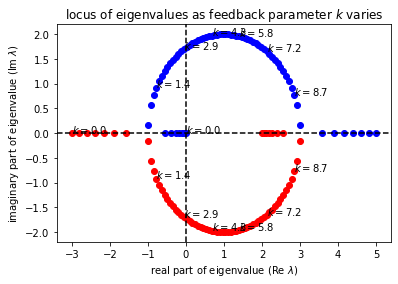

In [40]:
import numpy as np
import pylab as plt

# np.sqrt doesn't return complex numbers
# evaluating np.sqrt? brings up the "help", which points us to this replacement 
sqrt = np.lib.scimath.sqrt

#Choosing values of k for annotation
K = np.linspace(0,10,70)
lambda1 = (-(3 - K) + sqrt(((3 - K)**2) - 4*K)) / 2
lambda2 = (-(3 - K) - sqrt(((3 - K)**2) - 4*K)) / 2

# confirm the non-real eigenvalues are complex-conjugates
assert np.allclose(lambda1[np.abs(lambda1.imag) > 0.],
                   np.conj(lambda2[np.abs(lambda1.imag) > 0]))

#Axis labels
plt.title('locus of eigenvalues as feedback parameter $k$ varies')
plt.xlabel(r'real part of eigenvalue ($\operatorname{Re}\ \lambda$)')
plt.ylabel(r'imaginary part of eigenvalue ($\operatorname{Im}\ \lambda$)')

#Plotting values
plt.scatter(lambda1.real,lambda1.imag,color='b')
plt.scatter(lambda2.real,lambda2.imag,color = 'r')
# we'll only annotate every 10 of the computed eigenvalues
for k,lam1,lam2 in list(zip(K,lambda1,lambda2))[::10]:
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam1.real,lam1.imag))
  plt.annotate(r'$k=%0.1f$'%k,xy=(lam2.real,lam2.imag))
#x- and y- limits and drawing axes
ylim = plt.ylim()
plt.plot(np.zeros(2),ylim,'k--')
xlim = plt.xlim()
plt.plot(xlim,np.zeros(2),'k--')
plt.xlim(xlim); plt.ylim(ylim);